# Lab 0: Data Science Primer

Bias–variance, uncertainty, validation

> **Expected Time**
>
> -   FIN510: Seminar hands‑on ≈ 60 min;
> -   Directed learning extensions ≈ 90–120 min
> -   FIN720: Computer lab ≈ 120 min

<figure>
<a
href="https://colab.research.google.com/github/quinfer/fin510-colab-notebooks/blob/main/labs/lab00_primer.ipynb"><img
src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
<figcaption>Open in Colab</figcaption>
</figure>

> **How to use this lab**
>
> -   Work through the tasks in order and keep notes in your own
>     notebook.
> -   Reflection prompts are for your learning logs—there is **no
>     submission** for this lab.
> -   Bring insights back to the seminar to connect with the Week 0
>     slide discussion.

## Setup (Colab‑only installs)

In [1]:
# Run this cell in Colab if needed
try:
    import numpy, pandas, matplotlib
except Exception:
    !pip -q install numpy pandas matplotlib scipy

## Before You Start: The Big Picture

This primer lab builds foundations for rigorous financial data science.
We focus on three critical concepts that prevent costly errors in
production systems.

> **The Three Foundations You’ll Build**
>
> **1. Bias-Variance Trade-off** → Understanding when simpler models
> outperform complex ones  
> **2. Uncertainty Quantification** → Measuring confidence in your
> estimates (not just point estimates)  
> **3. Time-Aware Validation** → Preventing look-ahead bias in financial
> forecasting
>
> These aren’t abstract theory—they’re professional standards that
> separate robust production systems from research toys.

### What You’ll Build Today

By the end of this lab, you will have:

-   ✅ Visual intuition for the bias-variance trade-off
-   ✅ Working code for bootstrap confidence intervals
-   ✅ Understanding of walk-forward validation for time series
-   ✅ Diagnostic toolkit for financial return series

**Time estimate:** 60 minutes (FIN510) \| 90-120 minutes (FIN720 with
extensions)

> **🎯 Learning Philosophy**
>
> This lab emphasizes **pattern recognition over memorization**. You’ll
> see repeating patterns:
>
> -   Prepare data → Analyze/visualize → Validate results
> -   Generate synthetic data → Apply method → Interpret output
>
> Master these patterns here, apply them to real financial data in later
> labs.

## Orientation — Notebook Basics (10 min)

Let’s start with a quick orientation to ensure your Python environment
works correctly. This cell tests basic operations you’ll use throughout
the course.

In [2]:
# === Test 1: Basic output ===
print("Hello, notebook!")

# === Test 2: Variables and assertions ===
a = 2 + 2
assert a == 4, "Basic arithmetic check failed"

# === Test 3: Lists and slicing ===
nums = [10, 20, 30, 40]
assert nums[:2] == [10,20], "List slicing check failed"

# === Test 4: Dictionaries (used heavily in financial data) ===
info = {"ticker": "AAPL", "price": 185.0}
assert "ticker" in info and isinstance(info["price"], (int,float)), "Dictionary check failed"

# === Test 5: Functions ===
def add(x, y):
    return x + y
assert add(2,3) == 5, "Function check failed"

print("✔ All orientation checks passed - you're ready to proceed!")

Hello, notebook!
✔ All orientation checks passed - you're ready to proceed!

> **Understanding Assertions**
>
> The `assert` statements are quality checks. If something fails, you
> get an immediate error message rather than silent bugs later. This is
> defensive programming—a professional standard.

## Objectives

-   Visualize bias–variance trade‑off on synthetic data
-   Compute bootstrap confidence intervals  
-   Practice time‑aware validation (walk‑forward schematic)
-   Diagnose stylized facts in return series

## Task 1 — Bias–Variance Curves

The bias-variance trade-off is fundamental to model selection. Simple
models underfit (high bias), complex models overfit (high variance). The
optimal model balances both.

> **The Key Insight**
>
> **Total Error = Bias² + Variance + Irreducible Noise**
>
> -   **Bias²**: Error from wrong assumptions (underfitting)
> -   **Variance**: Error from sensitivity to training data
>     (overfitting)
> -   **Sweet spot**: Minimum MSE where bias and variance balance

### Step 1: Generate the trade-off curves

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Model complexity scale (1 = very simple, 10 = very complex)
complexity = np.arange(1, 11)

# Bias decreases with complexity (simple models underfit)
bias2 = (1/complexity)**1.2

# Variance increases with complexity (complex models overfit)
variance = 0.03 * (complexity/10)**1.8

# Total error (MSE) = Bias² + Variance
mse = bias2 + variance

# Find the optimal complexity
optimal_idx = np.argmin(mse)
optimal_complexity = complexity[optimal_idx]
optimal_mse = mse[optimal_idx]

print(f"Optimal complexity: {optimal_complexity}")
print(f"Minimum MSE: {optimal_mse:.4f}")

Optimal complexity: 10
Minimum MSE: 0.0931

### Step 2: Visualize the trade-off

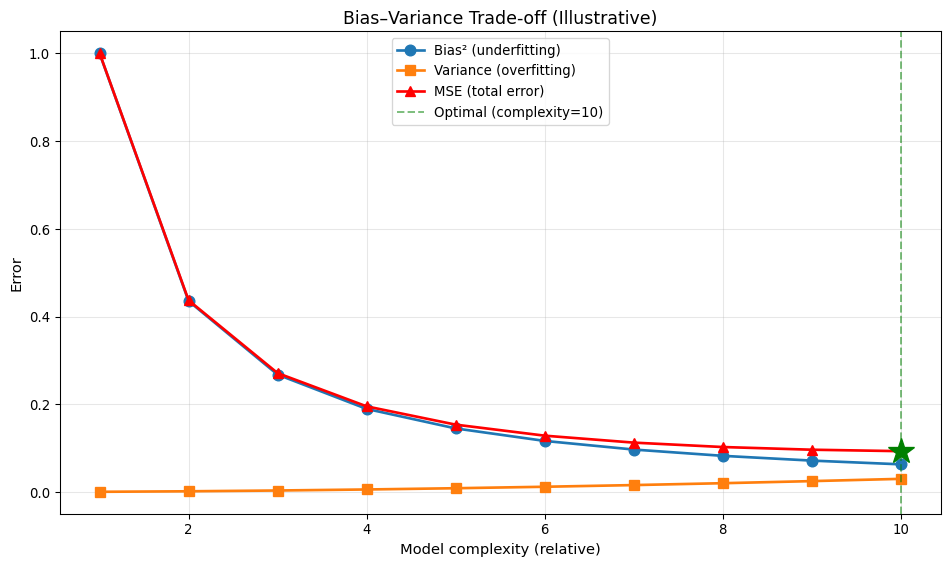

In [4]:
plt.figure(figsize=(10,6))

# Plot the three curves
plt.plot(complexity, bias2, 'o-', label='Bias² (underfitting)', linewidth=2, markersize=8)
plt.plot(complexity, variance, 's-', label='Variance (overfitting)', linewidth=2, markersize=8)
plt.plot(complexity, mse, '^-', label='MSE (total error)', linewidth=2, markersize=8, color='red')

# Mark the optimal point
plt.axvline(optimal_complexity, color='green', linestyle='--', alpha=0.5, 
            label=f'Optimal (complexity={optimal_complexity})')
plt.plot(optimal_complexity, optimal_mse, 'g*', markersize=20)

plt.xlabel('Model complexity (relative)', fontsize=11)
plt.ylabel('Error', fontsize=11)
plt.title('Bias–Variance Trade‑off (Illustrative)', fontsize=13)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

> **Reading the Chart**
>
> -   **Left side** (low complexity): Bias dominates → model too simple
> -   **Right side** (high complexity): Variance dominates → model too
>     flexible
> -   **Green line**: The sweet spot where MSE is minimized

**Checkpoint:** Where is MSE minimized? Explain why adding more
complexity beyond this point **hurts** performance despite “fitting” the
training data better.

## Task 2 — Bootstrap CI for Mean

Point estimates (like “mean return = 8%”) are incomplete—we need
**uncertainty quantification**. Bootstrap resampling lets us estimate
confidence intervals without assuming distribution shape.

> **Bootstrap Intuition**
>
> **The Problem:** We have one sample, but want to know “how variable is
> our estimate?”  
> **The Solution:** Resample our data many times (with replacement) and
> see how estimates vary
>
> **Process:** 1. Draw random sample from our data (with replacement,
> same size) 2. Calculate statistic (e.g., mean) 3. Repeat 1000-5000
> times 4. Use percentiles of bootstrap distribution as confidence
> interval

### Step 1: Generate sample data

In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(3)

# Simulate log-normal returns (realistic: positive skew, fat tail)
x = np.random.lognormal(mean=0.0, sigma=0.5, size=300)

print(f"Sample size: {len(x)}")
print(f"Sample mean: {np.mean(x):.4f}")
print(f"Sample std: {np.std(x, ddof=1):.4f}")

Sample size: 300
Sample mean: 1.1694
Sample std: 0.6455

> **Why Lognormal?**
>
> Financial returns often have positive skew (occasional large gains)
> and fat tails. Lognormal captures this better than normal
> distribution.

### Step 2: Perform bootstrap resampling

In [6]:
# Number of bootstrap iterations
B = 2000

# Store bootstrap means
boot_means = []

for i in range(B):
    # Resample with replacement (same size as original)
    xb = np.random.choice(x, size=len(x), replace=True)
    
    # Calculate mean of this bootstrap sample
    boot_means.append(np.mean(xb))

# Convert to array for analysis
boot_means = np.array(boot_means)

print(f"Generated {B} bootstrap samples")
print(f"Mean of bootstrap means: {np.mean(boot_means):.4f}")
print(f"Std of bootstrap means: {np.std(boot_means):.4f}")

Generated 2000 bootstrap samples
Mean of bootstrap means: 1.1705
Std of bootstrap means: 0.0370

### Step 3: Calculate confidence interval

In [7]:
# 95% confidence interval: use 2.5th and 97.5th percentiles
ci_low, ci_high = np.percentile(boot_means, [2.5, 97.5])

print(f"\n95% Bootstrap Confidence Interval:")
print(f"Lower bound: {ci_low:.4f}")
print(f"Point estimate: {np.mean(x):.4f}")
print(f"Upper bound: {ci_high:.4f}")

# Sanity check: point estimate should be inside CI
assert ci_low < np.mean(x) < ci_high, "Point estimate outside CI!"
print("\n✔ Bootstrap CI computed successfully")


95% Bootstrap Confidence Interval:
Lower bound: 1.1017
Point estimate: 1.1694
Upper bound: 1.2473

✔ Bootstrap CI computed successfully

### Step 4: Visualize the bootstrap distribution

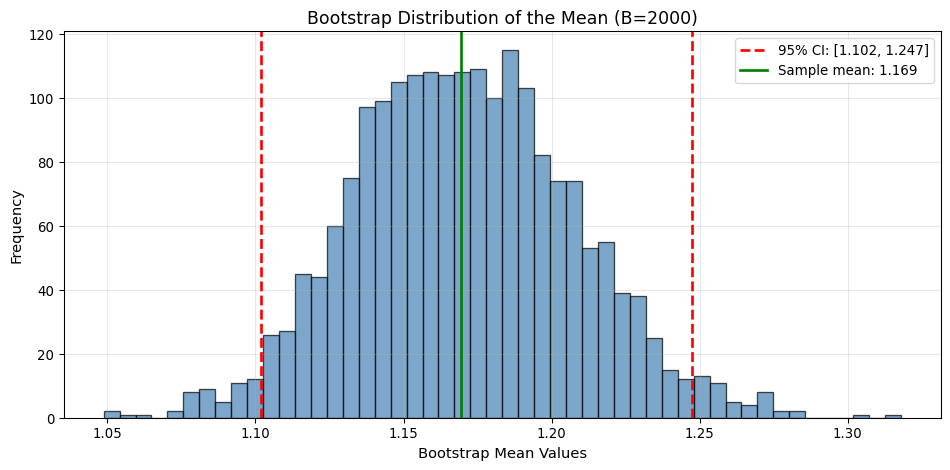

In [8]:
plt.figure(figsize=(10,5))

# Histogram of bootstrap means
plt.hist(boot_means, bins=50, alpha=0.7, color='steelblue', edgecolor='black')

# Mark the confidence interval
plt.axvline(ci_low, color='red', linestyle='--', linewidth=2, label=f'95% CI: [{ci_low:.3f}, {ci_high:.3f}]')
plt.axvline(ci_high, color='red', linestyle='--', linewidth=2)
plt.axvline(np.mean(x), color='green', linestyle='-', linewidth=2, label=f'Sample mean: {np.mean(x):.3f}')

plt.xlabel('Bootstrap Mean Values', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Bootstrap Distribution of the Mean (B=2000)', fontsize=13)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

> **Interpretation**
>
> **What the 95% CI means (frequentist):** If we repeated this process
> many times, 95% of the intervals would contain the true population
> mean.
>
> **What it does NOT mean:** There’s NOT a 95% probability the true mean
> is in this interval. The true mean either is or isn’t in there—the
> probability refers to the **procedure**, not this specific interval.
>
> **Bayesian credible interval** (different concept): Given our data and
> prior beliefs, there’s a 95% probability the parameter is in this
> range. Requires specifying priors.

**Checkpoint:** Why does bootstrap work? Hint: think about the
relationship between sample-to-population and resample-to-sample.

## Task 3 — Walk‑Forward Validation Schematic

Financial data has temporal structure—you can’t randomly split
train/test without leaking future information into the past.
**Walk-forward validation** respects time ordering.

> **Why Random Splitting Fails in Finance**
>
> Standard k-fold cross-validation shuffles data randomly. In finance,
> this creates **look-ahead bias**:
>
> -   Model trained on 2023 data, tested on 2022 data → unrealistic!
> -   Information from the future leaks into the past
> -   Performance estimates are optimistically biased
>
> **Solution:** Always split by time, train on past, validate on future.

### Visualize walk-forward structure

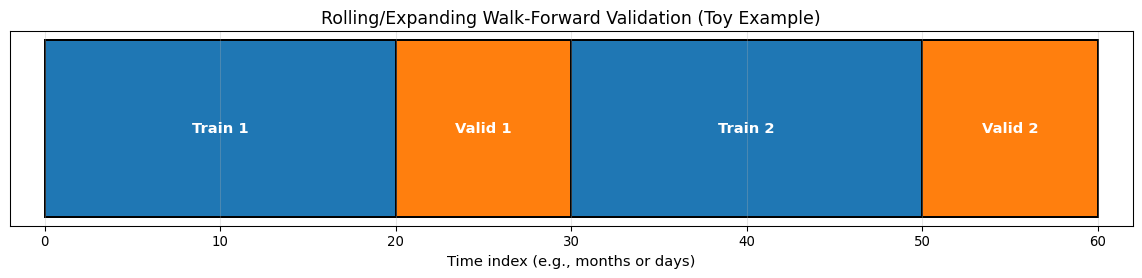

✔ Walk‑forward schematic drawn

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))

# Define training and validation windows
blocks = [
    (0, 20, 'Train 1'),  
    (20, 30, 'Valid 1'),  
    (30, 50, 'Train 2'),  # Expands: includes Train 1 + Valid 1
    (50, 60, 'Valid 2')
]

for start, end, label in blocks:
    # Color training blocks blue, validation blocks orange
    color = 'tab:blue' if 'Train' in label else 'tab:orange'
    
    plt.barh(0, end-start, left=start, height=0.6, color=color, edgecolor='black', linewidth=1.5)
    plt.text((start+end)/2, 0, label, ha='center', va='center', 
             color='white', fontsize=11, fontweight='bold')

plt.yticks([])
plt.xlabel('Time index (e.g., months or days)', fontsize=11)
plt.xlim(-2, 62)
plt.title('Rolling/Expanding Walk‑Forward Validation (Toy Example)', fontsize=13)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("✔ Walk‑forward schematic drawn")

> **Two Common Variants**
>
> 1.  **Rolling Window**: Train on last N periods only (e.g., Train 2
>     uses days 30-50)
>     -   Adapts quickly to regime changes
>     -   Less data per model
> 2.  **Expanding Window**: Train on all past data (e.g., Train 2 uses
>     days 0-50)
>     -   More stable estimates
>     -   Slower to adapt to structural breaks

**Deliverable:** Write one short paragraph on when to prefer simple
models despite recent evidence favoring complexity (Kelly, Malamud, and
Zhou (2022)). Consider: regime shifts, parameter estimation error,
interpretability requirements, regulatory constraints.

## Task 4 — Stylised-Fact Diagnostics

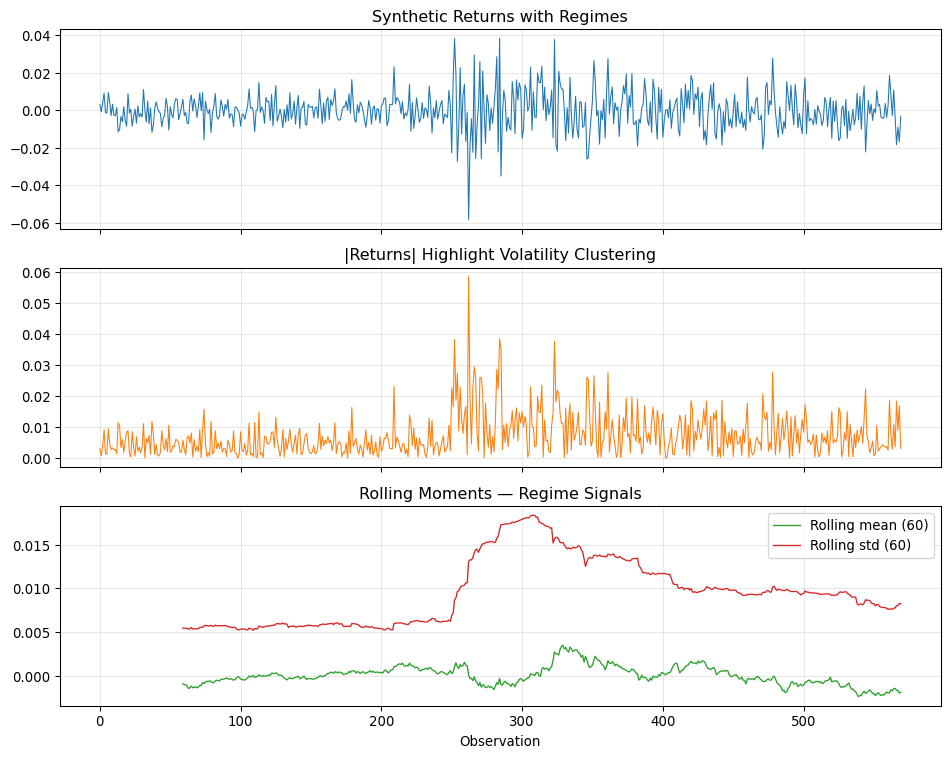

Kurtosis (Gaussian=3): 6.04
Autocorr |returns| lag 1: 0.25
Downside semivariance: 0.0001
Upside semivariance:   0.0001

In [10]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

np.random.seed(42)

# Synthetic returns with regime shifts to emphasise stylised facts
regimes = np.concatenate([
    np.random.normal(0, 0.6, size=250),
    np.random.normal(0, 1.8, size=120),
    np.random.normal(0, 0.9, size=200)
]) / 100
returns = pd.Series(regimes)

kurt = stats.kurtosis(returns, fisher=False)
acf_abs_lag1 = returns.abs().autocorr(lag=1)

downside = returns[returns < 0]
upside = returns[returns >= 0]
semivar_down = (downside ** 2).mean()
semivar_up = (upside ** 2).mean()

roll_mean = returns.rolling(60).mean()
roll_std = returns.rolling(60).std()

fig, ax = plt.subplots(3, 1, figsize=(10,8), sharex=True)
returns.plot(ax=ax[0], color='tab:blue', linewidth=0.8)
ax[0].set_title('Synthetic Returns with Regimes')
ax[0].grid(alpha=0.3)

returns.abs().plot(ax=ax[1], color='tab:orange', linewidth=0.8)
ax[1].set_title('|Returns| Highlight Volatility Clustering')
ax[1].grid(alpha=0.3)

roll_mean.plot(ax=ax[2], color='tab:green', linewidth=1, label='Rolling mean (60)')
roll_std.plot(ax=ax[2], color='tab:red', linewidth=1, label='Rolling std (60)')
ax[2].set_title('Rolling Moments — Regime Signals')
ax[2].legend()
ax[2].grid(alpha=0.3)
ax[2].set_xlabel('Observation')

plt.tight_layout()
plt.show()

print(f"Kurtosis (Gaussian=3): {kurt:.2f}")
print(f"Autocorr |returns| lag 1: {acf_abs_lag1:.2f}")
print(f"Downside semivariance: {semivar_down:.4f}")
print(f"Upside semivariance:   {semivar_up:.4f}")

-   Tail risk: how does the kurtosis compare to the Gaussian benchmark
    (3)?
-   Volatility memory: does the \|returns\| autocorrelation justify
    extra lags in your models?
-   Asymmetry: what do the downside vs upside semivariances imply for
    features?
-   Regime shifts: where do rolling mean/std change and how should
    validation windows respond?

Checkpoint: Draft a bullet list of features or diagnostics you would add
before escalating model complexity.

## Reflection — Complexity Decision Flow

Link your outputs back to the primer deck’s decision flow. In your
notes, capture 2–3 bullet points for each step:

1.  Evidence of richer signal (bias–variance + stylised facts)
2.  Baseline benchmark you would defend
3.  Validation design to test complexity honestly
4.  Governance checks before promoting Model B (Kelly, Malamud, and Zhou
    (2022))

> **Troubleshooting**
>
> -   If a plot is blank: check variable names and that x/y lengths
>     match.
> -   If a cell fails: run Setup, then Runtime → Restart and run all
>     (Colab).
> -   If numbers differ: verify random seeds and parameters.

## Governance & Failure Modes Checklist

-   Flag two potential leakage risks in your coursework dataset and note
    how you will test for them.
-   Assign a notional “model steward” and list what they must sign off
    before deployment.
-   Pick one explainability technique (e.g., SHAP, PDP) and describe how
    it would reduce black-box anxiety for stakeholders.

## Save Outputs (optional)

In [11]:
import matplotlib.pyplot as plt
plt.savefig('lab00_last_figure.png', dpi=150)
"Saved: lab00_last_figure.png"

'Saved: lab00_last_figure.png'

<Figure size 672x480 with 0 Axes>

## Exit Ticket (Optional, No Submission)

-   Dataset you will explore with a complex model and why it merits
    richer features.
-   Validation design you will implement to prove the complex model
    beats the baseline.
-   Governance or ethical concern you will monitor as you iterate.

> **Further Reading (Hilpisch 2019)**
>
> -   See our curated list: [Hilpisch Code
>     Resources](../resources/hilpisch-code.qmd) — Week 0 (Primer)
> -   Chapter 13 notebooks (statistics, ML workflows) show squared‑loss
>     diagnostics, residual analysis, and evaluation patterns consistent
>     with this lab.

Kelly, Bryan T., Semyon Malamud, and Kangying Zhou. 2022. “The Virtue of
Complexity in Return Prediction.” Working Paper w30217. National Bureau
of Economic Research. <https://doi.org/10.3386/w30217>.